# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]

train_features = ["tau21j1"] # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 1024 # Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00005
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")

# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)
df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# Normalize all inputs between -1 and 1

scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

del df
gc.collect()

Dataset consists of 732 batches of 1024 samples each, total 749568 samples
Testset consists of 244 batches of 1024 samples each, total 249856 samples


0

In [7]:
X_train

array([[-0.0744307 ],
       [-0.39868313],
       [-0.44746572],
       ...,
       [ 0.15598905],
       [-0.0737946 ],
       [-0.42850912]], dtype=float32)

(array([0.00970559, 0.15365518, 0.440954  , 0.73275542, 0.96258763,
        1.15263082, 1.29961503, 1.41481523, 1.52057504, 1.61142852,
        1.70738381, 1.76898597, 1.85326787, 1.91380132, 1.87798071,
        1.74460656, 1.52958022, 1.22463807, 0.8900135 , 0.57106196,
        0.33632738, 0.1743003 , 0.07824503, 0.02824963, 0.00283496]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ], dtype=float32),
 <a list of 25 Patch objects>)

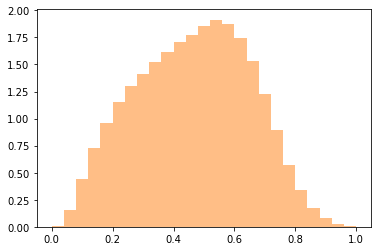

In [8]:
    plt.hist(scaler.inverse_transform(X_train), bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [11]:
generator = make_generator_model()

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [13]:
discriminator = make_discriminator_model()

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [16]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [17]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [18]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [19]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [20]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [21]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [22]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.normal([BATCH_SIZE,len(train_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [23]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [24]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.normal([BATCH_SIZE,len(train_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [25]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.title("N-subjettiness ratio")
    plt.ylabel("Normalized to Unity")
    plt.xlabel("$\\tau_{21J_2}$")
    plt.hist(scaler.inverse_transform(X_train), bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [26]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [27]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [28]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [31]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = False #((epoch + 1) % 20 == 0)
    draw_outputs = ((epoch + 1) % 1 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)
    print(train_gen_loss)
    print(train_disc_loss)
    print(len_dataset)
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)
    print(test_gen_loss)
    print(test_disc_loss)
    print(len_testset)

    # Logging

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)
      graph_genloss()
      graph_discloss()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

-25.813321713125333
970.642897925427
732
-28.488173753023148
74.23900985717773
244

Epoch 1:


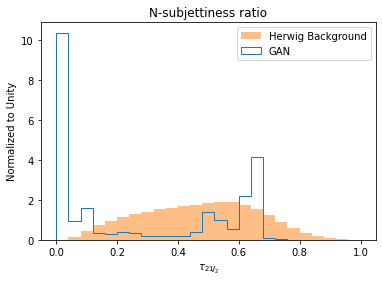

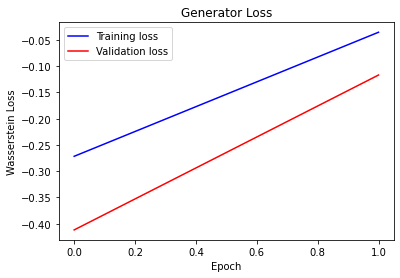

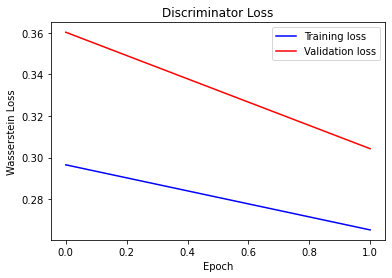

 10%|████████▎                                                                          | 1/10 [00:13<01:58, 13.13s/it]

43.71347414562479
826.8632827570946
732
-62.280751422047615
70.94457691907883
244

Epoch 2:


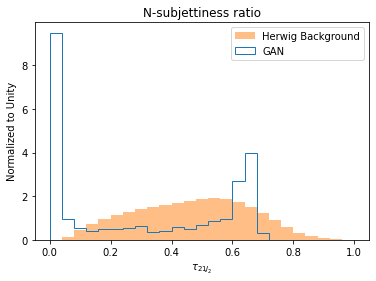

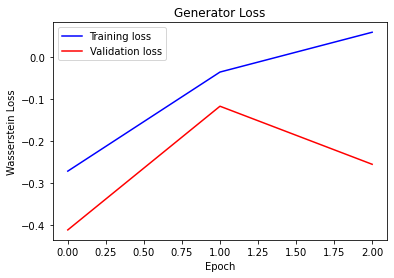

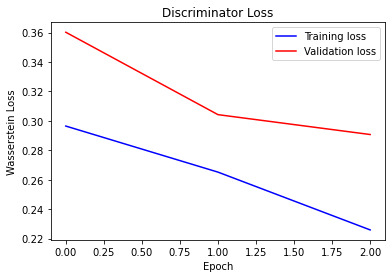

 20%|████████████████▌                                                                  | 2/10 [00:26<01:44, 13.07s/it]

9.306007530074567
653.1435528614093
732
-138.37252014875412
79.97506876289845
244

Epoch 3:


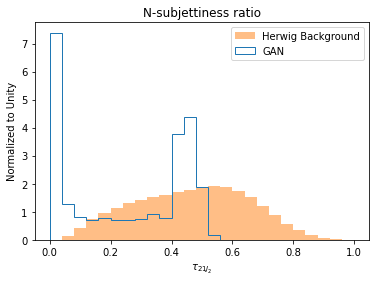

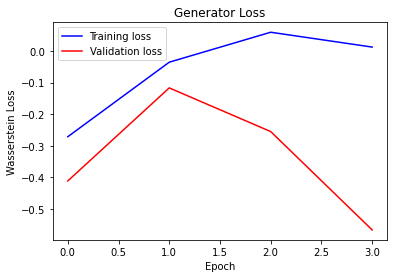

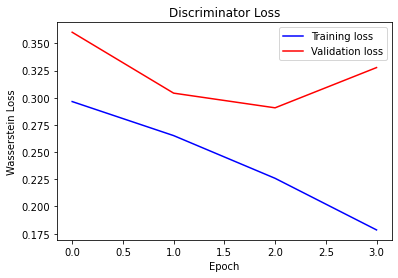

 30%|████████████████████████▉                                                          | 3/10 [00:38<01:31, 13.02s/it]

-53.911460613133386
385.6672388003208
732
-187.29323303699493
52.203862987458706
244

Epoch 4:


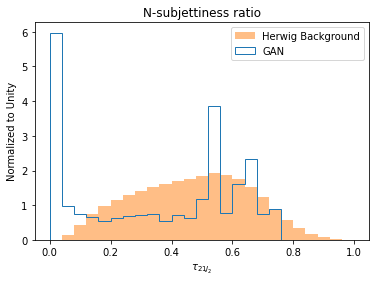

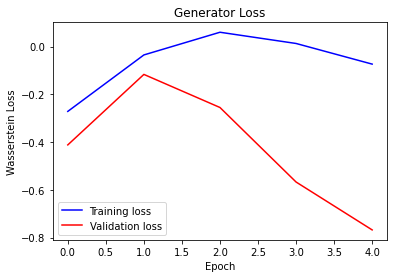

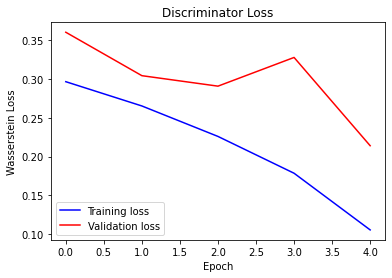

 40%|█████████████████████████████████▏                                                 | 4/10 [00:51<01:17, 13.00s/it]

-133.3652164787054
171.4665632568067
732
-232.3354759812355
35.14940111339092
244

Epoch 5:


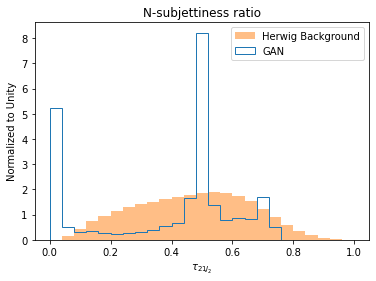

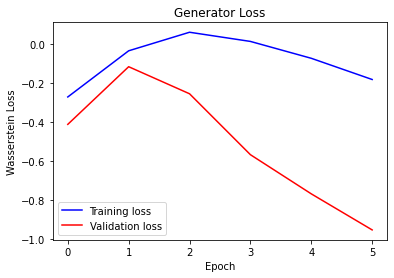

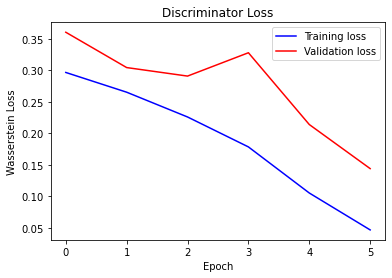

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:05<01:05, 13.14s/it]

-151.6987938284874
32.37797071934074
732
-214.0222315788269
0.7526823182997759
244

Epoch 6:


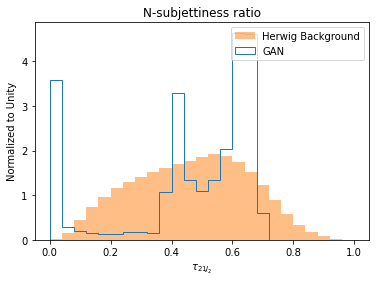

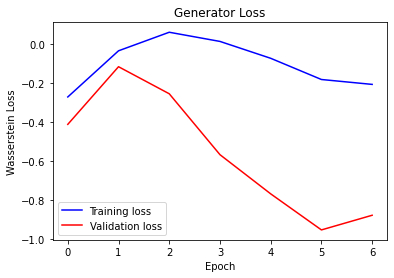

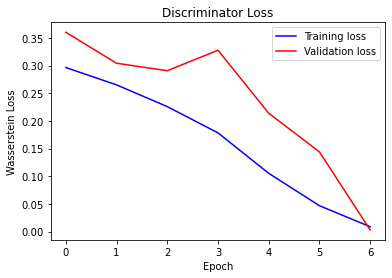

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:18<00:52, 13.18s/it]

-98.99195780605078
32.96090338637441
732
-222.68080419301987
5.629260500019882
244

Epoch 7:


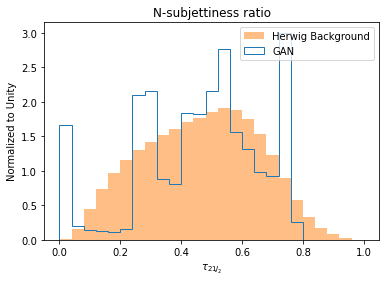

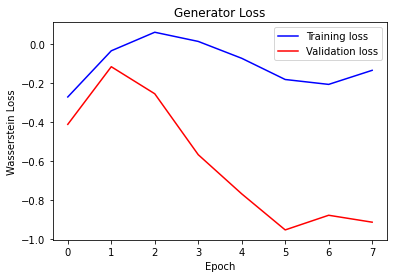

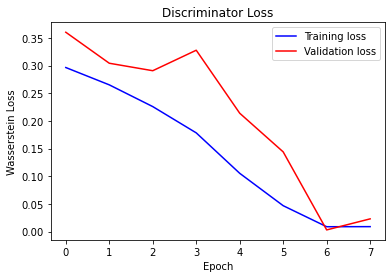

 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:31<00:39, 13.19s/it]

-132.1014543697238
37.29828999392703
732
-249.66302448511124
12.715589838451706
244

Epoch 8:


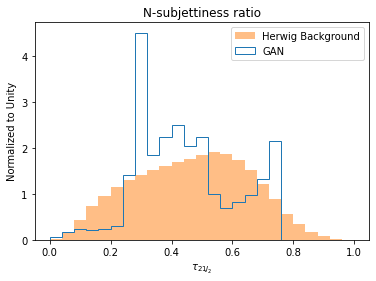

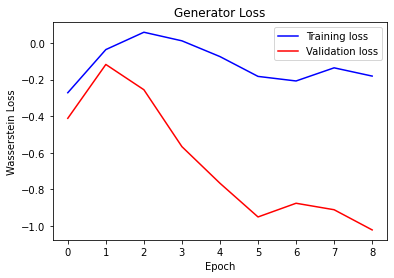

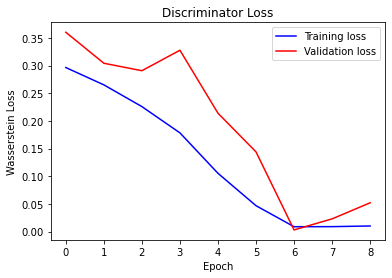

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:45<00:26, 13.21s/it]

-144.5308610200882
25.25035247737833
732
-253.09184974431992
12.978484187158756
244

Epoch 9:


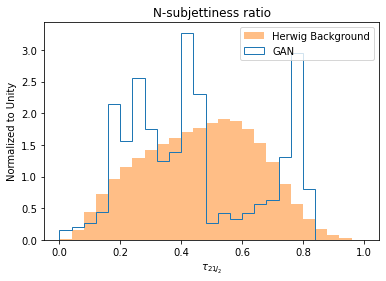

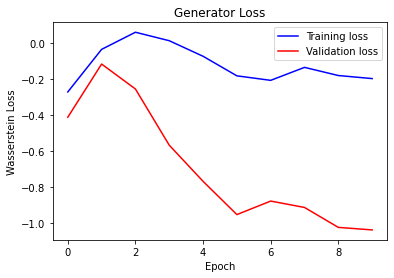

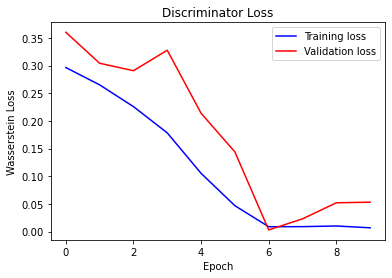

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:57<00:13, 13.06s/it]

-139.73495680838823
27.83474842279975
732
-236.34124678373337
-5.816503861336969
244

Epoch 10:


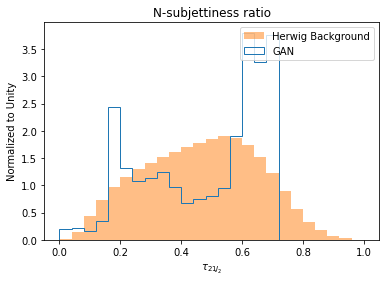

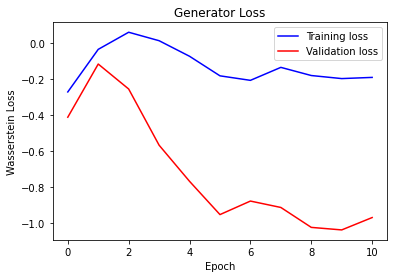

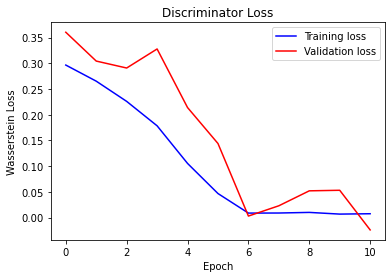

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:10<00:00, 13.10s/it]


In [32]:
train(train_dataset, test_dataset, 10, N_CRITIC)

## Results
???